In [65]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
# the libraries above are used to set seeds for replication purposes


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from workalendar.europe import Greece
cal = Greece()
# libraries for preprocessing

import tensorflow as tf
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential,Model
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import Input,Dense,LSTM,GRU,RNN
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1
from keras.regularizers import l2
#tensorflow and keras

from IPython.display import Image
from IPython.core.display import HTML 

In [66]:
data=pd.read_excel('all_data.xlsx')
validation_set=data.tail(5424)
data=data.head(21600)
data

,Date,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki
0,2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0
1,2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0
2,2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0
3,2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0
4,2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0
...,...,...,...,...,...,...,...,...
21595,2020-11-16 19:00:00,6407,13.5,1.0,74.5,11.5,2.0,88.0
21596,2020-11-16 20:00:00,6288,13.0,1.0,77.0,10.5,2.0,91.0
21597,2020-11-16 21:00:00,5948,12.5,1.0,79.5,10.0,2.0,94.0
21598,2020-11-16 22:00:00,5344,12.0,1.0,82.0,11.0,2.0,88.0


In [67]:
def working_days(df_date): # function to flag national holidays and weekends in Greece
    if cal.is_working_day(df_date):
        return 1
    else:
        return 0
    
data.index=data.Date
data['Month'] = data.index.month
data['Holiday_weekend']=data['Date'].apply(working_days)
data=data.reset_index(drop=True)
data

,Date,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Month,Holiday_weekend
0,2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0,6,1
1,2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0,6,1
2,2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0,6,1
3,2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0,6,1
4,2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0,6,1
...,...,...,...,...,...,...,...,...,...,...
21595,2020-11-16 19:00:00,6407,13.5,1.0,74.5,11.5,2.0,88.0,11,1
21596,2020-11-16 20:00:00,6288,13.0,1.0,77.0,10.5,2.0,91.0,11,1
21597,2020-11-16 21:00:00,5948,12.5,1.0,79.5,10.0,2.0,94.0,11,1
21598,2020-11-16 22:00:00,5344,12.0,1.0,82.0,11.0,2.0,88.0,11,1


# Scale Data

In [68]:
input_data=data[['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki']] # this is what we are going to use as input
output_data=data['Load'] # we only want to predict the load as output

input_scaler=MinMaxScaler() # scale all input data to [0,1] range
input_scaled=input_scaler.fit_transform(input_data)
input_scaled=pd.DataFrame(input_scaled)
input_scaled['Holiday_weekend']=data['Holiday_weekend']
input_scaled.columns=['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki','Holiday_weekend']


output_scaler=MinMaxScaler() # scale the output load to [0,1] range as well
output_scaled=output_scaler.fit_transform(np.array(output_data).reshape(-1,1))
output_scaled=pd.DataFrame(output_scaled)
output_scaled.columns=['Load']

filename1 = 'input_scaler.sav' # save the fitted scalers in a file
filename2 = 'output_scaler.sav'
pickle.dump(input_scaler, open(filename1, 'wb'))
pickle.dump(output_scaler, open(filename2, 'wb'))

C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [69]:
input_scaled.head(50)

,Load,Month,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Holiday_weekend
0,0.304439,0.454545,0.515789,0.333333,0.092664,0.543478,0.133333,0.450000,1
1,0.251980,0.454545,0.484211,0.266667,0.104247,0.543478,0.133333,0.466667,1
2,0.231654,0.454545,0.463158,0.266667,0.115830,0.543478,0.133333,0.433333,1
3,0.219997,0.454545,0.505263,0.333333,0.100386,0.500000,0.200000,0.508333,1
4,0.217456,0.454545,0.494737,0.133333,0.108108,0.489130,0.200000,0.525000,1
5,0.225527,0.454545,0.442105,0.000000,0.131274,0.478261,0.266667,0.500000,1
6,0.243013,0.454545,0.473684,0.400000,0.127413,0.489130,0.266667,0.504167,1
7,0.325362,0.454545,0.547368,0.266667,0.096525,0.554348,0.133333,0.404167,1
8,0.427589,0.454545,0.600000,0.266667,0.081081,0.608696,0.133333,0.358333,1
9,0.485279,0.454545,0.652632,0.200000,0.073359,0.630435,0.266667,0.425000,1


# Timeseries Forecasting with Sliding Window

In forecasting, we are interested in predicting future values of the timeseries based on historical data. In order to forecast with supervised learning methods such as neural networks, we should transform our data in input features and target or output features. In our case the target features should be the future values of electrical load, while the input features are the n past values of electrical load and weather data.

We can use the functions below to transform our dataset in this format. Each observation in our transformed data will be an array of n historical values while the corresponding target feature will be an array of 24 future values. 

Via this transformation, we are performing a **sliding window forecast**, in this case of size 24h. So every observation in our sample is shifted 24h later than the previous observation. This is called sliding window because every observation in our sample is **slided** by 24h forward.

![Sliding Window_1](https://raw.githubusercontent.com/ManosPra/ShortTermLoadForecasting-with-ANNs/main/Appendix/uber.PNG)
Source: https://eng.uber.com/forecasting-introduction/

![Sliding Window_2](https://raw.githubusercontent.com/ManosPra/ShortTermLoadForecasting-with-ANNs/main/Appendix/rolling_window_method.gif)

In this run, we use 96 past hours as the input size, 24h which is the sliding window size and 24 h as the desired output size.

In [70]:
# every split holds 96 hours (input size) that is 24h (sliding window size) later than the previous split

def create_x(x,y):
    generator = TimeseriesGenerator(x,y,length=96, batch_size=24) 
    input_x=[]
    output_y=[]
    for i in range(len(generator)):
        input_x.append(generator[i][0][0])
        output_y.append(generator[i][1][0])
    return (input_x)

def create_y(x,y): # we create y (output data) splitted every 24 hours (length of output we want to predict)
    generator = TimeseriesGenerator(x,y,length=24, batch_size=24)
    input_x=[]
    output_y=[]
    for i in range(len(generator)):
        input_x.append(generator[i][0][0])
        output_y.append(generator[i][1][0])
    return (input_x)

In [71]:
x=create_x(input_scaled.values,output_scaled.values)
y=create_y(output_scaled.values,input_scaled.values)

x=np.array(x)
y=np.array(y)
y=y[4:] #first 4 days (96 h) should be only in the input, so that the output contains future values of the correspondent input features

x is in 3d shape, since LSTM layers require data to be in **[samples,timesteps,features]** shape.

In [72]:
x=x[:y.shape[0]]
y=y.reshape(y.shape[0],y.shape[1])

We are going to use a total of 895 samples, where each sample is represented by 9 features and we use 96 values for each feature.

In [73]:
x.shape

(895, 96, 9)

In [74]:
y.shape

(895, 24)

In [75]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [76]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = Sequential()
model.add(LSTM(100,input_shape=(96, 9),return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50,return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(24,activation='sigmoid')) # sigmoid since we have scaled to [0,1]
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96, 100)           44000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1224      
Total params: 155,824
Trainable params: 155,824
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 0.01779, saving model to LSTM_model_96h.h5

Epoch 00002: val_loss improved from 0.01779 to 0.01711, saving model to LSTM_model_96h.h5

Epoch 00003: val_loss improved from 0.01711 to 0.01349, saving model to LSTM_model_96h.h5

Epoch 00004: val_loss improved from 0.01349 to 0.00867, saving model to LSTM_model_96h.h5

Epoch 00005: val_loss improved from 0.00867 to 0.00632, saving model to LSTM_model_96h.h5

Epoch 00006: val_loss did not improve from 0.00632

Epoch 00007: val_loss improved from 0.00632 to 0.00437, saving model to LSTM_model_96h.h5

Epoch 00008: val_loss improved from 0.00437 to 0.00411, saving model to LSTM_model_96h.h5

Epoch 00009: val_loss improved from 0.00411 to 0.00393, saving model to LSTM_model_96h.h5

Epoch 00010: val_loss improved from 0.00393 to 0.00343, saving model to LSTM_model_96h.h5

Epoch 00011: val_loss did not improve from 0.00343

Epoch 00012: val_loss did not improve from 0.00343

Epoch 00013: val_loss improv

<AxesSubplot:>

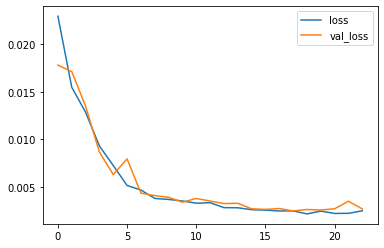

In [77]:
#batch is the number of samples that is shown to the network before a weight update is performed

n_epochs = 1000 # don't care much about epochs since we use early stopping
batch=32
model.compile(optimizer='adam', loss='mse') 

checkpointer = ModelCheckpoint(filepath="LSTM_model_96h.h5",
                               verbose=1,
                               save_best_only=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5) # early stopping

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=0,
                    callbacks=[checkpointer,es_callback])
df_loss = pd.DataFrame(history.history)
df_loss[['loss','val_loss']].plot()

In [ ]:
#reasonable learning curve

In [78]:
model = load_model('LSTM_model_96h.h5')
input_scaler= pickle.load(open("input_scaler.sav", "rb"))
output_scaler= pickle.load(open("output_scaler.sav", "rb"))
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

predictions_train = output_scaler.inverse_transform(predictions_train)
y_train=output_scaler.inverse_transform(y_train)

predictions_test = output_scaler.inverse_transform(predictions_test)
y_test=output_scaler.inverse_transform(y_test)

trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 317.19 RMSE
Test Score: 288.91 RMSE


In [ ]:
# probably test size should be bigger

<AxesSubplot:>

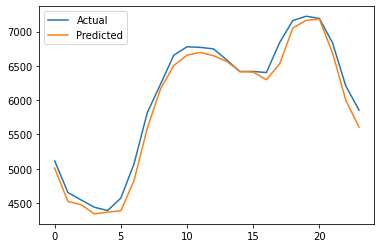

In [79]:
predictions=pd.DataFrame(predictions_test)
predictions['Day']=predictions.index +1
actual=pd.DataFrame(y_test)
actual['Day']=actual.index +1
actual=pd.melt(actual,id_vars=['Day'],var_name='Hour').sort_values(by=['Day','Hour']).reset_index(drop=True)
predicted=pd.melt(predictions,id_vars=['Day'],var_name='Hour').sort_values(by=['Day','Hour']).reset_index(drop=True)


joined=pd.DataFrame()
joined['Actual']=actual['value']
joined['Predicted']=predicted['value']
plot_data=joined[['Actual','Predicted']]

plot_data.head(24).plot()

<AxesSubplot:>

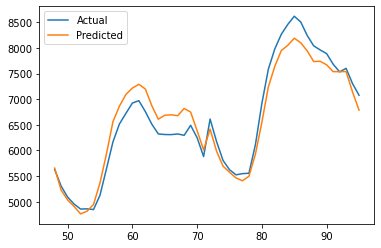

In [80]:
plot_data.iloc[48:96].plot()

<AxesSubplot:>

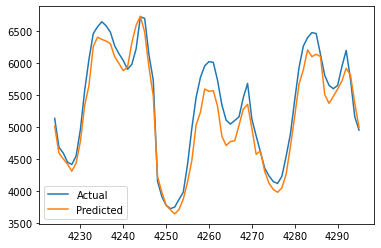

In [81]:
plot_data.tail(72).plot()

<AxesSubplot:>

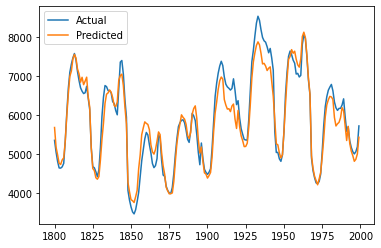

In [82]:
plot_data.iloc[1800:2000].plot()

<AxesSubplot:>

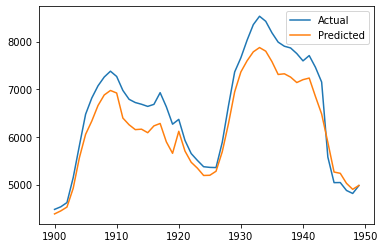

In [83]:
plot_data.iloc[1900:1950].plot()

<AxesSubplot:>

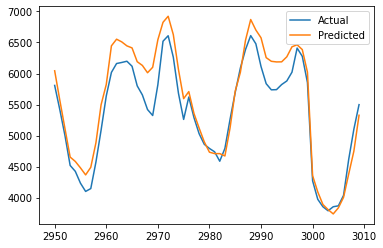

In [84]:
plot_data.iloc[2950:3010].plot()

With this model we can predict 24 future values of the electrical load using the past 96 values of load and weather data. We still face the issue of the forecasting horizon (since the model needs the exact n past values in order to predict the next 24) as in the feed forward models, but we can see that LSTM layers make better use of sequence data such as timeseries.

# Grid Search Parameters

We are interested in finding the optimal parameter values that will result in the lowest training error. After identifying those parameter, we can introduce reguralization (dropout, l1,l2 norm) to reduce overfitting.

In [38]:
# use the same functions as previously but use input length as a variable as well
def create_x(x,y,x_length): 
    generator = TimeseriesGenerator(x,y,length=x_length, batch_size=24) 
    input_x=[]
    output_y=[]
    for i in range(len(generator)):
        input_x.append(generator[i][0][0])
        output_y.append(generator[i][1][0])
    return (input_x)

def create_y(x,y): # keep the sliding window of size 24 and output size 24
    generator = TimeseriesGenerator(x,y,length=24, batch_size=24)
    input_x=[]
    output_y=[]
    for i in range(len(generator)):
        input_x.append(generator[i][0][0])
        output_y.append(generator[i][1][0])
    return (input_x)




def grid_search(scaler,input_size,batch,layer_type):
    
    ############### follow the same preprocessing pipeline ###################################
    
    input_data=data[['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki']]
    output_data=data['Load']
    input_scaler=scaler
    input_scaled=input_scaler.fit_transform(input_data)
    input_scaled=pd.DataFrame(input_scaled)
    input_scaled['Holiday_weekend']=data['Holiday_weekend']
    input_scaled.columns=['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki','Holiday_weekend']
    output_scaler=scaler
    output_scaled=output_scaler.fit_transform(np.array(output_data).reshape(-1,1))
    output_scaled=pd.DataFrame(output_scaled)
    output_scaled.columns=['Load']
    filename1 = 'input_scaler.sav'
    filename2 = 'output_scaler.sav'
    pickle.dump(input_scaler, open(filename1, 'wb'))
    pickle.dump(output_scaler, open(filename2, 'wb'))
    
    x=create_x(input_scaled.values,output_scaled.values,input_size)
    y=create_y(output_scaled.values,input_scaled.values)
    x=np.array(x)
    y=np.array(y)
    flag_point=int(input_size/24)
    y=y[flag_point:]
    x=x[:y.shape[0]]
    y=y.reshape(y.shape[0],y.shape[1])
    
    ################### Train & Test Split ###########################################
    
    temp_train_scores=[]
    temp_test_scores=[]
    finish_point=0
    
    while finish_point < 5: #for every model try 5 different train test splits and average results from all splits
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=finish_point)

    #################### Build Model #################################################
        tf.keras.backend.clear_session()
        tf.random.set_seed(0)
        model = Sequential()
        model.add(layer_type(100,input_shape=(input_size, 9),return_sequences=True))
        model.add(layer_type(100,return_sequences=False))
        model.add(Dense(24,activation='sigmoid'))

        n_epochs = 1000 
        batch=batch
        model.compile(optimizer='adam', loss='mse')
        checkpointer = ModelCheckpoint(filepath="load_model.h5",
                                       verbose=0,
                                       save_best_only=True)
        es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # early stopping
        history = model.fit(x_train, y_train,
                            epochs=n_epochs,
                            batch_size=batch,
                            shuffle=True,
                            validation_split=0.20,
                            verbose=0,
                            callbacks=[checkpointer,es_callback])

    ################# load trained model and make predictions ################################
        model = load_model('load_model.h5')
        input_scaler= pickle.load(open("input_scaler.sav", "rb"))
        output_scaler= pickle.load(open("output_scaler.sav", "rb"))
        predictions_train = model.predict(x_train)
        predictions_test = model.predict(x_test)

        predictions_train = output_scaler.inverse_transform(predictions_train)
        y_train=output_scaler.inverse_transform(y_train)

        predictions_test = output_scaler.inverse_transform(predictions_test)
        y_test=output_scaler.inverse_transform(y_test)

        trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
        testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
        temp_train_scores.append(trainScore)
        temp_test_scores.append(testScore)
        finish_point += 1
    
    print('Train Score: %.2f RMSE' % (sum(temp_train_scores)/len(temp_train_scores)))
    print('Test Score: %.2f RMSE' % (sum(temp_test_scores)/len(temp_test_scores)))
    return(sum(temp_train_scores)/len(temp_train_scores),sum(temp_test_scores)/len(temp_test_scores))

In [39]:
import warnings
warnings.filterwarnings('ignore')

layer_types=[keras.layers.LSTM, keras.layers.GRU, keras.layers.RNN]
input_sizes=[24,48,72,96] # transform data with all these input sizes
batch_sizes=[None,15,32,64] # try these batch sizes
train_scores=[]
test_scores=[]
inputs=[]
batches=[]
nn_layers=[]

for k in layer_types:
    for i in input_sizes:
        for j in batch_sizes:
            print('Input Size:' + str(i))
            print('Batch Size:' + str(j))
            print('Layer Type:' + str(k))
            print('|---------------------| :')
            tr,te=grid_search(MinMaxScaler(),i,j,k)
            train_scores.append(tr)
            test_scores.append(te)
            inputs.append(i)
            batches.append(j)
            nn_layers.append(k)

Input Size:24
Batch Size:None
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|---------------------| :
Train Score: 398.04 RMSE
Test Score: 411.45 RMSE
Input Size:24
Batch Size:15
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|---------------------| :
Train Score: 401.79 RMSE
Test Score: 415.46 RMSE
Input Size:24
Batch Size:32
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|---------------------| :
Train Score: 401.73 RMSE
Test Score: 412.92 RMSE
Input Size:24
Batch Size:64
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|---------------------| :
Train Score: 417.74 RMSE
Test Score: 428.87 RMSE
Input Size:48
Batch Size:None
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|---------------------| :
Train Score: 313.14 RMSE
Test Score: 322.86 RMSE
Input Size:48
Batch Size:15
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|---------------------| :
Train Score: 320.87 RMSE
Test Score: 327.61 RMSE
Input Size:48
Batch Size:32
Layer Type:<class 'keras.layers.recurrent.LSTM'>
|------

KeyboardInterrupt: 

In [40]:
my_dict = {'Input_Size': inputs,'Batch_Size': batches, 'Train_Score': train_scores, 'Test_Score': test_scores}  
df = pd.DataFrame(my_dict)
df 

,Input_Size,Batch_Size,Train_Score,Test_Score
0,24,NaN,398.042353,411.453055
1,24,15.0,401.785383,415.461257
2,24,32.0,401.732151,412.922716
3,24,64.0,417.740931,428.872236
4,48,NaN,313.142276,322.859357
5,48,15.0,320.870379,327.605094
6,48,32.0,322.299027,329.099179
7,48,64.0,332.454271,335.442168
8,72,NaN,306.650367,331.638115
9,72,15.0,309.163050,334.654241


In [41]:
df.loc[df['Train_Score'].idxmin()]

Input_Size      72.000000
Batch_Size            NaN
Train_Score    306.650367
Test_Score     331.638115
Name: 8, dtype: float64

In [42]:
df.loc[df['Test_Score'].idxmin()]

Input_Size      48.000000
Batch_Size            NaN
Train_Score    313.142276
Test_Score     322.859357
Name: 4, dtype: float64

# Trying Best Model on Validation set

We are now going to train a model with all data we used previously for training and testing and validate the forecasting accuracy on the small validation set we kept at the beginning. We are going to build a model with **LSTM layers** of input size **72 past hours** **without setting a batch size**.

In [85]:
input_data=data[['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki']]
output_data=data['Load'] 

input_scaler=MinMaxScaler() # scale all input data to [0,1] range
input_scaled=input_scaler.fit_transform(input_data)
input_scaled=pd.DataFrame(input_scaled)
input_scaled['Holiday_weekend']=data['Holiday_weekend']
input_scaled.columns=['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki','Holiday_weekend']


output_scaler=MinMaxScaler() # scale the output load to [0,1] range as well
output_scaled=output_scaler.fit_transform(np.array(output_data).reshape(-1,1))
output_scaled=pd.DataFrame(output_scaled)
output_scaled.columns=['Load']

filename1 = 'input_scaler.sav' # save the fitted scalers in a file
filename2 = 'output_scaler.sav'
pickle.dump(input_scaler, open(filename1, 'wb'))
pickle.dump(output_scaler, open(filename2, 'wb'))

C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [86]:
def create_x(x,y):
    generator = TimeseriesGenerator(x,y,length=72, batch_size=24) 
    input_x=[]
    output_y=[]
    for i in range(len(generator)):
        input_x.append(generator[i][0][0])
        output_y.append(generator[i][1][0])
    return (input_x)

def create_y(x,y): # we create y (output data) splitted every 24 hours (length of output we want to predict)
    generator = TimeseriesGenerator(x,y,length=24, batch_size=24)
    input_x=[]
    output_y=[]
    for i in range(len(generator)):
        input_x.append(generator[i][0][0])
        output_y.append(generator[i][1][0])
    return (input_x)


x=create_x(input_scaled.values,output_scaled.values)
y=create_y(output_scaled.values,input_scaled.values)

x=np.array(x)
y=np.array(y)
y=y[3:] #first 3 days (72 h) should be only in the input, so that the output contains future values of the correspondent input features

In [87]:
x=x[:y.shape[0]]
y=y.reshape(y.shape[0],y.shape[1])
print(x.shape)
print(y.shape)

(896, 72, 9)
(896, 24)


In [88]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
model = Sequential()
model.add(LSTM(100,input_shape=(72, 9),return_sequences=True))
model.add(Dropout(0.2)) # introduce dropout between layers, to reduce overfitting
model.add(LSTM(100,return_sequences=False))
model.add(Dense(24,activation='sigmoid'))

n_epochs = 1000 
model.compile(optimizer='adam', loss='mse', metrics=['mape']) # also report the Mean Absolute Percentage Error at each epoch
checkpointer = ModelCheckpoint(filepath="best_load_model_sliding_window_24.h5",
                               verbose=1,
                               save_best_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5) # early stopping
history = model.fit(x, y, # now use the whole dataset (without splitting to train and test)
                    epochs=n_epochs,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1,
                    callbacks=[checkpointer,es_callback])

Train on 716 samples, validate on 180 samples
Epoch 1/1000
716/716 [==============================] - 7s 10ms/step - loss: 0.0196 - mape: 12932.5752 - val_loss: 0.0166 - val_mape: 38.1824

Epoch 00001: val_loss improved from inf to 0.01660, saving model to best_load_model_sliding_window_24.h5
Epoch 2/1000
716/716 [==============================] - 6s 8ms/step - loss: 0.0118 - mape: 13769.7510 - val_loss: 0.0132 - val_mape: 35.5518

Epoch 00002: val_loss improved from 0.01660 to 0.01318, saving model to best_load_model_sliding_window_24.h5
Epoch 3/1000
716/716 [==============================] - 5s 7ms/step - loss: 0.0065 - mape: 8852.4902 - val_loss: 0.0100 - val_mape: 21.0274

Epoch 00003: val_loss improved from 0.01318 to 0.01003, saving model to best_load_model_sliding_window_24.h5
Epoch 4/1000
716/716 [==============================] - 5s 7ms/step - loss: 0.0069 - mape: 9079.4961 - val_loss: 0.0053 - val_mape: 20.5511

Epoch 00004: val_loss improved from 0.01003 to 0.00530, saving m

In [89]:
model.save_weights("best_load_model_sliding_window_24_weights")

<AxesSubplot:>

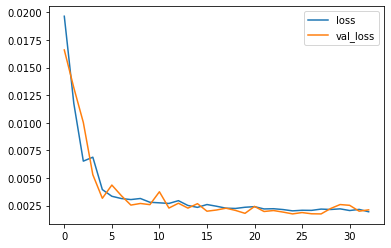

In [90]:
df_loss = pd.DataFrame(history.history)
df_loss[['loss','val_loss']].plot()

In [91]:
validation_set.index=validation_set.Date
validation_set['Month'] = validation_set.index.month
validation_set['Holiday_weekend']=validation_set['Date'].apply(working_days)
validation_set=validation_set.reset_index(drop=True)
validation_set.head(20)

,Date,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Month,Holiday_weekend
0,2020-11-17 00:00:00,4561,12.5,1.5,79.5,11.0,2.0,88.0,11,1
1,2020-11-17 01:00:00,4259,12.0,2.0,82.0,12.0,2.0,88.0,11,1
2,2020-11-17 02:00:00,4220,12.0,2.0,82.0,14.0,1.0,88.0,11,1
3,2020-11-17 03:00:00,4135,11.5,1.0,85.0,14.0,1.5,82.0,11,1
4,2020-11-17 04:00:00,4075,11.0,1.0,88.0,13.0,1.0,88.0,11,1
5,2020-11-17 05:00:00,4185,11.0,2.0,88.0,12.0,1.0,88.0,11,1
6,2020-11-17 06:00:00,4525,10.5,1.0,91.0,11.5,1.0,91.0,11,1
7,2020-11-17 07:00:00,4977,11.0,1.0,88.0,11.0,1.0,94.0,11,1
8,2020-11-17 08:00:00,5597,14.0,1.0,82.0,12.5,1.0,85.0,11,1
9,2020-11-17 09:00:00,6100,15.5,0.0,74.5,14.0,1.0,82.0,11,1


In [92]:
input_data=validation_set[['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki']] 
output_data=validation_set['Load'] 

input_scaled=input_scaler.transform(input_data)
input_scaled=pd.DataFrame(input_scaled)
input_scaled['Holiday_weekend']=data['Holiday_weekend']
input_scaled.columns=['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki','Holiday_weekend']


output_scaled=output_scaler.transform(np.array(output_data).reshape(-1,1))
output_scaled=pd.DataFrame(output_scaled)
output_scaled.columns=['Load']

In [93]:
x=create_x(input_scaled.values,output_scaled.values)
y=create_y(output_scaled.values,input_scaled.values)

x=np.array(x)
y=np.array(y)
y=y[3:]

x=x[:y.shape[0]]
y=y.reshape(y.shape[0],y.shape[1])
print(x.shape)
print(y.shape)

(222, 72, 9)
(222, 24)


In [94]:
model = load_model('best_load_model_sliding_window_24.h5')

predictions_validation_set = model.predict(x)
predictions_validation_set = output_scaler.inverse_transform(predictions_validation_set)

y_actual=output_scaler.inverse_transform(y)


val_score = math.sqrt(mean_squared_error(y_actual, predictions_validation_set))
print('Validation Set Score: %.2f RMSE' % (val_score))

Validation Set Score: 520.02 RMSE


<AxesSubplot:>

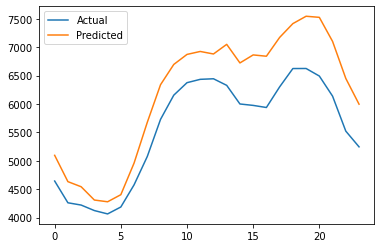

In [95]:
predictions=pd.DataFrame(predictions_validation_set)
predictions['Day']=predictions.index +1
actual=pd.DataFrame(y_actual)
actual['Day']=actual.index +1
actual=pd.melt(actual,id_vars=['Day'],var_name='Hour').sort_values(by=['Day','Hour']).reset_index(drop=True)
predicted=pd.melt(predictions,id_vars=['Day'],var_name='Hour').sort_values(by=['Day','Hour']).reset_index(drop=True)


joined=pd.DataFrame()
joined['Actual']=actual['value']
joined['Predicted']=predicted['value']
plot_data=joined[['Actual','Predicted']]

plot_data.head(24).plot()

<AxesSubplot:>

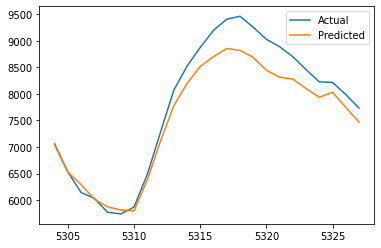

In [96]:
plot_data.tail(24).plot()

<AxesSubplot:>

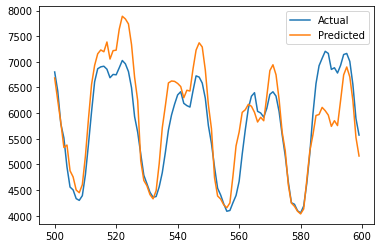

In [97]:
plot_data.iloc[500:600].plot()

In [104]:
plot_data['Absolute Percentage Error']=(abs(plot_data['Actual']-plot_data['Predicted'])/plot_data['Actual'])*100
plot_data['Absolute Error']=abs(plot_data['Actual']-plot_data['Predicted'])
plot_data['Residual']=plot_data['Actual']-plot_data['Predicted']
plot_data

,Actual,Predicted,Absolute Percentage Error,Absolute Error,Residual
0,4644.0,5096.739258,9.748907,452.739258,-452.739258
1,4261.0,4633.348145,8.738515,372.348145,-372.348145
2,4221.0,4543.667969,7.644349,322.667969,-322.667969
3,4124.0,4309.540527,4.499043,185.540527,-185.540527
4,4065.0,4278.804199,5.259636,213.804199,-213.804199
...,...,...,...,...,...
5323,8456.0,8099.465820,4.216346,356.534180,356.534180
5324,8225.0,7936.286133,3.510199,288.713867,288.713867
5325,8216.0,8029.471680,2.270306,186.528320,186.528320
5326,7987.0,7744.774414,3.032748,242.225586,242.225586


In [105]:
plot_data['Absolute Percentage Error'].mean()

6.939853569621376

In [106]:
plot_data['Absolute Error'].mean()

389.52771953777506

<AxesSubplot:>

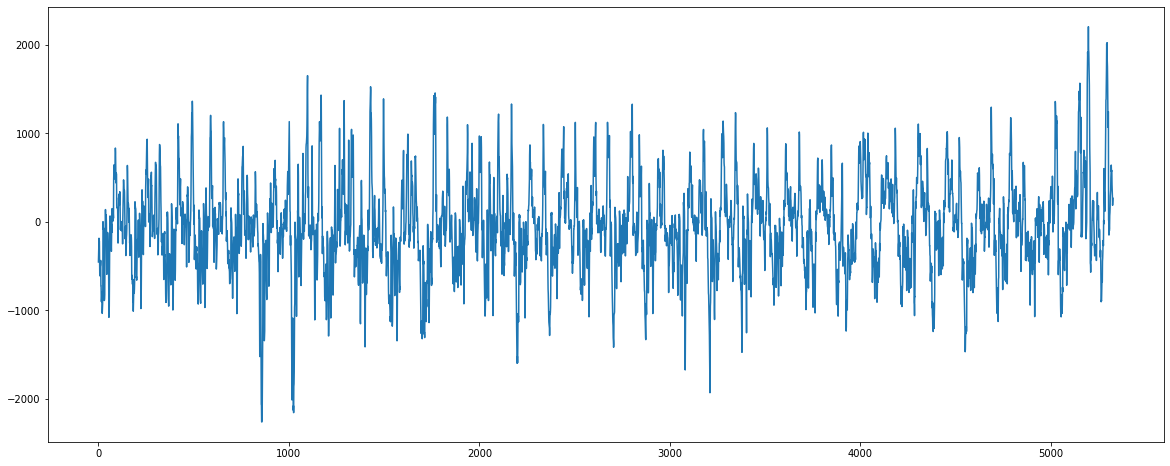

In [112]:
plot_data['Residual'].plot(figsize=(20,8))

<AxesSubplot:>

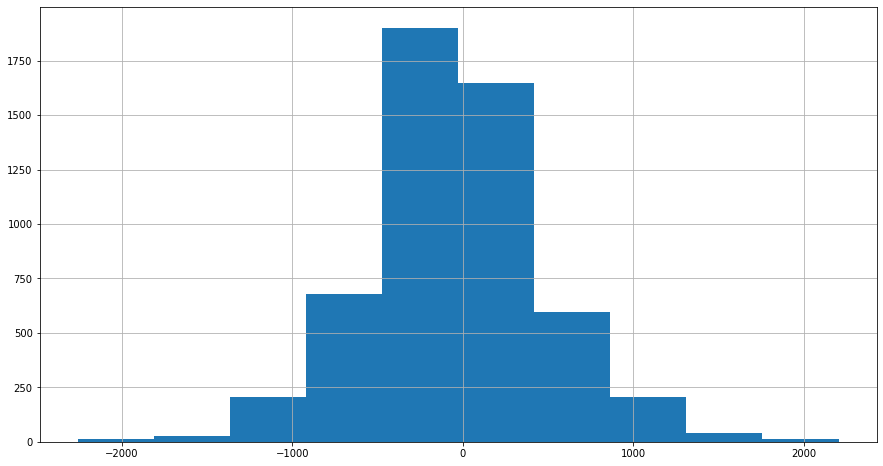

In [114]:
plot_data['Residual'].hist(figsize=(15,8))

The residuals appear to be normaly distributed centered around 0. These are the results we would expect our model to have in a real case scenario.